In [103]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 30 09:59:03 2021

@author: andy & ben
"""
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.style
import configparser
import re
import math
import time
import tkinter as tk
from tkinter import *

from PIL import Image, ImageTk
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

#import matplotlib.image as mpimg
#from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox


class Evaluation:

    list_results=[]     #List results
    Data=pd.DataFrame() #To store all results in one DataFrame
    plot_confi={}

    def readConfig(self, home_directory):
        print('Including values from configuration file\n')
        self.config = configparser.ConfigParser()
        self.config.optionxform=str
        self.file=home_directory +'\profileconfig.ini'
        ret=self.config.read(self.file)
        self.sections=self.config.sections()
        #print("sections",self.sections,"return",ret)
        for i in range(len(self.sections)):
            Evaluation.plot_confi[self.sections[i]] = dict(self.config.items(self.sections[i]))
        print('Configuration completed\n')

    def load_df(self,directory_list,path):
        
        df_dict={}
        list_folders = directory_list
        
        #saves a df dictionary with results from json files
        for datafolder in list_folders:
            working_directory = path+chr(92)+datafolder
            #print('working directory: ', working_directory)
            os.chdir(working_directory)   #Jump in datafolder
            df_dict[datafolder]=pd.DataFrame()
            Data=pd.DataFrame()
            list_results =[]
            i=0
            while i in range(len(os.listdir())):
                for files in os.listdir():
                    #print(files)
                    if files.endswith('.json'):
                        file=open(files,'r')            #open json file
                        file_load=json.load(file)       #load json file
                        list_results.append(file_load[0])  #fill list with results of the loaded json file
                        #Data.append(list_results[i],ignore_index=True)  
                        if i==0:
                            Data=pd.DataFrame.from_dict(list_results[0],orient='index')
                        Data[i]=pd.DataFrame.from_dict(list_results[i],orient='index')
                    i+=1
                df_dict[datafolder] = Data.T

        return df_dict

    def loadfiles(self,directory):

        #Loads json files and returns a Dataframe
        #You can take a look into the shape of the returned df with the commnd df.info
        os.chdir(directory)

        self.listfiles=os.listdir() #Get a list of all files stored in target directory

        '''Load files in DataFrame'''
        for i in range(len(self.listfiles)):

             self.file=open(self.listfiles[i],'r')        #Open file
             self.file_load=json.load(self.file)          #Load from file
             Ev.list_results.append(self.file_load[0])    #Take the Data of the file that is stored in first list entry
             if i==0:                           #
                 Ev.Data=pd.DataFrame.from_dict(Ev.list_results[0],orient='index')    #initialize DataFrame
             Ev.Data[i]=pd.DataFrame.from_dict(Ev.list_results[i],orient='index')     #Add columns from list_results to df
        Data2=Ev.Data.T
        return Data2

    def convertunits(self, dataframetoconvert):
        #Change the values and units from the values that are set to "on" in the config file
        #Return a new dataframe and a list with elements to be plotted
        self.list_to_be_print=[] #list with elements to be plotted

        print('Change datatype of:\n')
        for item in Ev.plot_confi['plots']:


            if Ev.plot_confi['plots'][item] == 'on': #item = column name as a str

                self.list_to_be_print.append(item)
                print(item)

                for val in range(len(dataframetoconvert[item])):
                    temp_string=dataframetoconvert.loc[val,item]
                    if type(dataframetoconvert.loc[val,item]) !='float':
                        #dataframetoconvert.loc[val,item]=int(temp_string[:temp_string.rfind('.')])
                        dataframetoconvert.loc[val,item]=float(re.findall(r'[\d.]+',temp_string)[0])
                    else:
                        dataframetoconvert.loc[val,item]=(re.findall(r'[\d.]+',temp_string)[0])

        dataframetoconvert['NumThreadsPerBlock*NumBlocksPerGrid']=dataframetoconvert['NumThreadsPerBlock']*dataframetoconvert['NumBlocksPerGrid']
        dataframetoconvert['NumThreadsPerBlock*NumBlocksPerGrid']=dataframetoconvert['NumThreadsPerBlock*NumBlocksPerGrid'].astype('int')
        return dataframetoconvert,self.list_to_be_print


    def convertunits_2(self,dataframes,metrics_to_save):

        dataframes_threated={}

        for df in dataframes:
            # reduce dataframes
            temp_df =pd.DataFrame()
            try:
                temp_df = dataframes[df][['NumIterations','NumThreadsPerBlock', 'NumBlocksPerGrid']+metrics_to_save]
                columns_to_convert = metrics_to_save

                for column in columns_to_convert:
                    for val in range(len(temp_df[column])):
                        temp_string=temp_df.loc[val,column]

                        temp_df.loc[val,column]=int(float(re.findall(r'[\d.]+',temp_string)[0]))
                temp_df['gridsize']=temp_df['NumThreadsPerBlock']*temp_df['NumBlocksPerGrid']
                temp_df['gridsize']=temp_df['gridsize'].astype(int)
                dataframes_threated[df]=temp_df
            except:
                dataframes_threated = None
            
        return dataframes_threated
    
    
    def max_results(self, df, optimal_results_list, analysis_type):
    #Finds the maximum, or optimal, result of the selected analysis type
    #The function returns a list with the optimal results, along with contextual information about it
        
        result_type_list = []
        max_list = []
        gridsize_list = []
        threadsPerBlock_list = []
        
        for optimal_result in optimal_results_list:         
            max_spot = 0
            
            #Finds max result
            max_tp = df[optimal_result][0]
            for count in range(len(df[optimal_result])):
                if df[optimal_result][count] > max_tp:
                    max_tp = df[optimal_result][count]
                    max_spot = count
            max_list.append(max_tp)
            gridsize_list.append(df['gridsize'][max_spot])            
            threadsPerBlock_list.append(df['NumThreadsPerBlock'][max_spot])
            max_tp2=max(df[optimal_result])
            
        #results_list[0] == list of optimal results
        #results_list[1] == list of gridsizes for the optimal results 
        #results_list[2] == list of threadsPerBlock for the optimal results 
        results_list =[max_list,gridsize_list,threadsPerBlock_list]
        return results_list

    
    #Method that produces single-directory-analysis plots.
    def plots(self,df,plotlist,y_axis_scale,Ev): 
        list_of_figures = [None]*len(plotlist)
        
        for count in range(len(plotlist)):
            fig = plt.figure()
            ax = fig.add_subplot()
            yaxis = plotlist[count]

            #set figure size
            fig.set_size_inches(12,7)

            #remove frame
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)

            #enable grid
            plt.rcParams['grid.linestyle']=':'
            ax.yaxis.grid()

            #setup x-axis
            ax.set_xscale('log')
            plt.xticks(df['gridsize'])
            ax.set_xticklabels(df['gridsize'],rotation=75,size=13.5)

            #setup y-axis
            #logarithmic scale
            if y_axis_scale == 'log':
                plt.ylim((min(df[yaxis])-min(df[yaxis])*0.30),max(df[yaxis])*3)
                ax.set_yscale('log')
            #linear scale
            elif y_axis_scale == 'linear':
                plt.ylim(0,max(df[yaxis])*1.3)
            
            plt.yticks(size=13.5)

            #Labels and titel
            plt.xlabel('Gridsize',fontsize=13.5)
            plt.ylabel('Troughput\n'+yaxis,fontsize=13.5)
            plt.title(yaxis,fontsize=15)
            plt.gcf().subplots_adjust(bottom=0.2)
            
            #Get maximum values for each dataset
            maxima_y=max(df[yaxis])
             

            for k in sorted(df['NumThreadsPerBlock'].unique(),reverse=True):
                    d=df.loc[df['NumThreadsPerBlock']==k]
                    local_max = max(d[yaxis])
                    #print(local_max)
                    #if local_max < maxima_y:
                    color = Ev.color(k)
                    edgecolor = 'black'
                    #else:
                        #color = 'red'
                        #edgecolor = 'red'
                    ax.scatter(
                        d['gridsize'],
                        d[yaxis],
                        label=k,
                        s=k*2,
                        c=color,
                        alpha=Ev.al(k),
                        edgecolors= edgecolor
                        )
                    ax.legend(loc='upper left',title='Threads Per Block',prop={'size':15})
                    plt.xticks(df['gridsize'])

            #plt.text(16400, 250000, 'Here we have space for some\nfurther information like:\n\nCuda\nepoch2\ngg_ttgg',fontsize=25)
            #fig.savefig('/home/andy/cernbox/data/raw/data'+'epoch2_ee_mumu_gcheck_float'+yaxis)
            
            list_of_figures[count] = fig
        return list_of_figures
            

    def data_compare2(self,df_dict,compare_list, plotlist, y_axis_scale):
        #Takes a dictionary with dataframes and plots it in the same scatter plot 
        
        list_of_figures = [None]*len(plotlist)
        for count in range(len(plotlist)):
            fig = plt.figure()
            ax1 = fig.add_subplot()
            fig.set_size_inches(16,6)

            #remove frame
            ax1.spines['right'].set_visible(False)
            ax1.spines['top'].set_visible(False)

            #enable grid
            plt.rcParams['grid.linestyle']=':'
            plt.grid()

            #setup x axis
            ax1.set_xscale('log')
            current_df_dict = df_dict[count]
            plt.xticks(current_df_dict[list(current_df_dict.keys())[count]]['gridsize'])
            ax1.set_xticklabels(current_df_dict[list(current_df_dict.keys())[count]]['gridsize'],rotation=75)

            #setup y axis
            #get maximum value of all df for ylim
            max_y = [max(current_df_dict[df][plotlist[count]]) for df in current_df_dict]
            #plt.ylim(-0.1*10**9,max(max_y)*1.3)

            #logarithmic y-axes
            if y_axis_scale == 'log':
                ax1.set_yscale('log')
                plt.ylim(10**5,max(max_y)*10)
                plt.yticks(size=13.5)
            #linear y-axes
            elif y_axis_scale == 'linear':
                plt.ylim(0,max(max_y)*1.3)

            #Add labels and title (and margins)
            title = 'Throughput\n '+ plotlist[count]
            plt.ylabel(title)
            plt.xlabel('Gridsize')
            plt.title('Cuda throughput for ee_mumu on NVIDIA T4\n')
            plt.gcf().subplots_adjust(bottom=0.2, right=0.5)

            #Change colormap. More info here https://matplotlib.org/stable/tutorials/colors/colormaps.html
            cmap=plt.get_cmap('Set1')

            i=1
            for data in compare_list:
                #Get maximum values for each dataset
                maxima_y=max(current_df_dict[data][plotlist[count]])
                maxima_x=current_df_dict[data].loc[current_df_dict[data][plotlist[count]]==maxima_y,'gridsize'].item()

                #label maximum values
                length=len(str(maxima_y))-1
                label_maximas=str(round(maxima_y*10**-(length),3))+'e'+str(length)

                #plot datasets
                ax1.scatter(current_df_dict[data]['gridsize'].to_list(),current_df_dict[data][plotlist[count]].to_list(),
                            label=data+ ' (max = %s)'%label_maximas,
                            color=cmap(i),
                            s=150,alpha=0.9)
                #Get next cmap color
                i+=1

            #plot datasets
            ax1.scatter(maxima_x,maxima_y,c='r',marker='o',s=50)  
            ax1.legend(loc=(1.04,0.6))
            list_of_figures[count] = fig
        return list_of_figures
    
    
    def bar_chart(self,results,optimal_results_list,directories):
        #Produces bar charts compareing best results when analysing multiple directories
        
        list_of_figures = [None]*len(optimal_results_list)
        color_list = [None]*len(directories)
        
        #defines color
        cmap=plt.get_cmap('Set1')           
        
        #produces bar chart
        for count in range(len(optimal_results_list)):
            fig = plt.figure()
            fig.set_size_inches(16,6)
            ax2 = plt.subplot()
            x_label_list = []
            results_list = []
            count2_list = [None]*len(directories)
            legend_list = [None]*len(directories)
            
            #produces each individual bar seperatly so they can be referenced in the legend
            for count2 in range(len(directories)):
                gridsize = results[count2][1][count]
                threadsPerBlock = results[count2][2][count]
                x_label_temp = 'Gridsize: '+str(gridsize)+'\n '+'ThreadsPerBlock: '+str(threadsPerBlock)
                result_temp = results[count2][0][count]
                color_list[count2]=cmap(count2+1)  
                
                #label maximum values
                length=len(str(result_temp))-1
                label_maximas=str(round(result_temp*10**-(length),3))+'e'+str(length)
                legend_list[count2] = directories[count2]+' (max = %s)'%label_maximas
                
                
                ax2.bar(count2+1, result_temp, color=color_list[count2])                
                count2_list[count2] = count2+1
                x_label_list.append(x_label_temp)
                results_list.append(result_temp)
              
            #print(x_label_list,results_list)
            
            #remove frame
            ax2.spines['right'].set_visible(False)
            ax2.spines['top'].set_visible(False)
            
            #Set up x-axis
            plt.xticks(count2_list)
            ax2.set_xticklabels(x_label_list, rotation=75)            

            #enable grid
            plt.rcParams['grid.linestyle']=':'
            plt.grid()
            
            #Add labels and title (and margins)
            title = 'Optimal Results for '+ optimal_results_list[count]+'\n'
            plt.title(title)
            plt.ylabel(optimal_results_list[count]) 
            ax2.legend(legend_list, loc=(1.04,0.6))
            plt.gcf().subplots_adjust(bottom=0.3, right=0.5)
            
            list_of_figures[count] = fig
            #plt.show()    
            
        return list_of_figures
                       


    def dataframes_statistical_transfomation(self,df_dict, plot_element, stat):
        #This functions takes a dictionary of dataframes and returns a dictionary with dataframes
        #where the dataframes contain only the gridsize values according to the statistical expression
        #which was given to the function like max, min, etc..
        df_dict_to_return={}
        
        #Get a list of gridsize
        gridsize = sorted(df_dict[list(df_dict.keys())[0]]['gridsize'].astype(int).unique())
        for df in df_dict:
            df_dict_to_return[df]=pd.DataFrame()
            for gs in gridsize:
                temp_df=df_dict[df][(df_dict[df]['gridsize']==gs)]

                if temp_df.empty:
                    pass
                else:
                    df_dict_to_return[df]=df_dict_to_return[df].append(temp_df[(temp_df[plot_element]
                                                                      ==eval(stat)(temp_df[plot_element]))])
                    df_dict_to_return[df]=df_dict_to_return[df].astype({'gridsize':int})
        return df_dict_to_return

    def al(self,value):
        if value == 32:
            self.alpha = .5
        elif value == 64:
            self.alpha = 0.75
        elif value == 128:
            self.alpha = 0.75
        elif value == 256:
            self.alpha=1
        return self.alpha

    def color(self,value):
        if value == 32:
            self.col = 'midnightblue'
        elif value == 64:
            self.col = 'sienna'
        elif value == 128:
            self.col = 'aqua'
        elif value == 256:
            self.col='lightcyan'
        return self.col


In [104]:
#Screens class containing all the user interface elements 
class screens:
    
    def __init__(self):
        
        self.screen_to_display = 1
        self.data_directory_list = []
        self.profiling_results_list = []
        self.options_list = []
        self.next_screen_var = 1
        self.analysis_type = None
        self.axis_type = None
        self.graphcount = 0
        self.error = False

    
    def run(self,home_directory):
    
        Ev = Evaluation()
        self.first_screen()
        
        if  self.next_screen_var == 2:
            Ev.readConfig(home_directory) #reads the configuration file
            data_directory_path = home_directory + '\profiling_results'
            try:
                self.profiling_results_list = os.listdir(data_directory_path) #List of data directories
            except:
                error_message = "could not find the directory: \n"+data_directory_path
                self.error = True

            #Only lists directories within path and ignores any files
            for data_directory in self.profiling_results_list:
                directory_path = data_directory_path +chr(92)+ data_directory
                if os.path.isdir(directory_path):
                    self.data_directory_list.append(data_directory)
            
            #Error checking
            try:
                #Creates a list of selected plot options (metrics) from config file
                plot_list=[item for item in Ev.plot_confi['plots']if Ev.plot_confi['plots'][item] == 'on']
                if not plot_list:
                    error_message = "The config file does not have any of the options selected."
                    self.error = True
            except:
                error_message = "The config file does not appear to be configured properly."
                self.error = True            
           
            if not self.error:
                self.second_screen(plot_list)
            else:
                self.error_screen(error_message)
            
        if self.next_screen_var == 3:
            #Processing of user choice
            optimal_results_list =[]
            plot_list_to_analyse = []
            metrics_to_analyse = []
            
            for count in range(len(plot_list)): 
                #Creates a list of the perameters selected to be ploted
                if  self.options_list[0][count].get() == 1:
                    plot_list_to_analyse.append(plot_list[count])
                #Creates a list of the perameters selected to be find optimal results
                if  self.options_list[1][count].get() == 1:
                    optimal_results_list.append(plot_list[count])
                #Creates a list of the perameters that must be analysed in the datadirectories
                if self.options_list[0][count].get() == 1 or self.options_list[1][count].get() == 1:
                    metrics_to_analyse.append(plot_list[count])
            
            y_axis_scale = self.options_list[2].get()

            #Creates a list of the selected data directories to be analysed
            directories_to_analyse_list = []
            if self.analysis_type.get() == 1:
                directory_to_analyse = self.data_directory_list[self.options_list[3][0].get()]
                directories_to_analyse_list.append(directory_to_analyse)     
            elif self.analysis_type.get() == 2:
                for count in range(len(self.data_directory_list)):
                    if self.options_list[3][count].get() == 1:
                        directory_to_analyse = self.data_directory_list[count]
                        directories_to_analyse_list.append(directory_to_analyse)
            
            if directories_to_analyse_list:
                dataframes=Ev.load_df(directories_to_analyse_list, data_directory_path) 
                #returns a pd dataframe that contains relevant data from selected datafolders

                dataframes_conv=Ev.convertunits_2(dataframes,metrics_to_analyse) 
                #returns a df directory with converted units, units to be graphed for options selected
                if not dataframes_conv:
                    self.error = True
                    error_message = 'Had trouble reading files from a directory, please ensure files are formatted properly'
            else:
                self.error = True
                error_message = 'No data directories have been selected'
            
            #Produces plots
            if not self.error:
                list_of_max_results = []
                if self.analysis_type.get() == 1:
                    #produces list of plots
                    list_of_plots = Ev.plots(dataframes_conv[directories_to_analyse_list[0]],
                                             plot_list_to_analyse, y_axis_scale,Ev)
                    #produces list of the max results
                    list_of_max_results = Ev.max_results(dataframes_conv[directories_to_analyse_list[0]],
                                                         optimal_results_list,self.analysis_type.get())
                    
                    if list_of_max_results or list_of_plots:
                        self.third_screen(list_of_plots,list_of_max_results,metrics_to_analyse,home_directory)
                    else:
                        self.error = True
                        error_message = 'There was an error when processing the selected metrics'

                elif self.analysis_type.get() == 2:
                    dataframes_statisical = [None]*len(metrics_to_analyse)
                    df_conv_list = [None]
                    for count in range(len(metrics_to_analyse)):
                        dataframes_statisical[count]=Ev.dataframes_statistical_transfomation(dataframes_conv, 
                                                                                             metrics_to_analyse[count],'max')
                    for directory in directories_to_analyse_list:
                        #produces 3D array containing the max results for the bar chart along with information about the results  
                        list_of_max_results.append(Ev.max_results(dataframes_conv[directory],
                                                                  optimal_results_list,self.analysis_type.get()))
                    #produces list of plots
                    list_of_plots = Ev.data_compare2(dataframes_statisical,
                                                     directories_to_analyse_list, plot_list_to_analyse, y_axis_scale)
                    #produces list of bar charts
                    list_of_bar_charts = Ev.bar_chart(list_of_max_results, 
                                                      optimal_results_list,directories_to_analyse_list)

                    self.third_screen(list_of_plots, list_of_bar_charts,metrics_to_analyse, home_directory)
            
            if self.error:
                self.error_screen(error_message)

    def error_screen(self, error_message):
        window=Tk()
        window.geometry("+300+40")
        
        window.title('ERROR')
        error_lbl=Label(window, text="An error has occured:", 
                  fg='black', font=("Helvetica", 12))
        error_lbl.grid(column=0, row=0, sticky=tk.N, padx=20, pady=5)
        message_lbl=Label(window, text=error_message, 
                  fg='black', font=("Helvetica", 12))
        message_lbl.grid(column=0, row=1, sticky=tk.N, padx=20, pady=5)
        window.mainloop()
    
                
    def graph(self, figure_list, window, nature):
        #Draws disired graph onto Tk window
        if nature == 'next':
            #print('next')
            if self.graphcount < len(figure_list)-1:
                self.graphcount += 1
        elif nature == 'previous':
            #print('pervious')
            if self.graphcount > 0:
                self.graphcount -= 1
        
        canvas = FigureCanvasTkAgg(figure_list[self.graphcount], master=window)  
        canvas.draw()
        canvas.get_tk_widget().grid(column=0,columnspan=10, row=1,rowspan=24, sticky=tk.NW, padx=20, pady=10)
        
        graph_counter = str(self.graphcount+1)+'/'+str(len(figure_list))
        graph_numb_lbl=Label(window, text=graph_counter, fg='black', font=("Helvetica", 12))
        graph_numb_lbl.grid(column=1, row=0, sticky=tk.NW, padx=5, pady=10)
    
    #Saves selected graph in 'plots' subdirectory
    def save(self, figure_list, window, graph_name, home_directory):
        #Creates list of already saved plots
        plot_directory_path = home_directory+'\plots'
        try: 
            saved_plots = os.listdir(plot_directory_path) #List of data directories
            #Checks if a plot already has the same name
            new_name = True
            for graph in saved_plots:
                existing_name = '.'.join(graph.split('.')[:-1])
                current_name = graph_name.get()
                if existing_name.lower() == current_name.lower():
                    new_name = False
            if new_name:                
                if graph_name.get() and ' ' not in graph_name.get():
                    figure_list[self.graphcount].savefig(home_directory+'\plots'
                                                         +chr(92)+graph_name.get(), dpi=100)
                else:
                     graph_name.set( "Name contains invalid characters" )
            else:
                graph_name.set("Name Already Taken")
        except:
            error_message = "could not find the directory:  \n "+plot_directory_path
            window.destroy()
            self.error_screen(error_message)
        
            
    #Returns the number of the next screen            
    def next_screen(self, screen_number):
        self.next_screen_var = 1 + screen_number
        return self.next_screen_var
    

    #First screen allows user to choose to analyse a single directory or multiple directories
    def first_screen(self):
        
        window=Tk()
        window.geometry("+300+40")
        
        self.analysis_type=IntVar()
        self.analysis_type.set(1)
        
        window.title('Evaluation Screen 1/3')
        lbl=Label(window, text="Would you like to analyse multiple directories or just one?", 
                  fg='black', font=("Helvetica", 12))
        lbl.grid(column=0,columnspan=2, row=0, sticky=tk.N, padx=20, pady=10)
        
        #Choice of type of analysis
        single_directory_choice=Radiobutton(window, text="Single Directory", variable=self.analysis_type,value=1)
        multiple_directory_choice=Radiobutton(window, text="Multiple Directories", variable=self.analysis_type,value=2)
        
        single_directory_choice.grid(column=0,row=1, sticky=E, padx=5, pady=5)
        multiple_directory_choice.grid(column=1,row=1, padx=5, pady=5)
        
        next_btn=Button(window, text="Next", fg='black',font=("Helvetica", 12),
                        command=lambda: [self.next_screen(self.next_screen_var), window.destroy()])
        next_btn.grid(column=1, row=2, sticky=tk.SE, padx=5, pady=5)
        window.mainloop()
            
        
    
    #the second screen allows user to configure the analysis before running it
    def second_screen(self, plot_list):
        
        #Set up screen
        window=Tk()
        window.title('Evaluation Screen 2/3')
        window.geometry("+300+40")         
        
        #Screen config for single directory analysis
        if self.analysis_type.get() == 1:
            print('Single directory analysis')

            directories_to_analyse_var = [0]
            directories_to_analyse_var[0]=IntVar()
            directories_to_analyse_var[0].set(0)
            data_directory_display = [None]*len(self.data_directory_list)
            
            #Displays the selectable data directories
            for count in range(len(self.data_directory_list)):
                data_directory_display[count]=Radiobutton(window, text=self.data_directory_list[count], 
                                                          variable=directories_to_analyse_var[0],value=count)
                data_directory_display[count].grid(column=0, columnspan=3,row=count+1, sticky=tk.W, padx=10, pady=0)
            
            directory_title_txt = "Select a directory to analyse:"
            optimal_results_txt = 'Display Optimal Result'   
            
        #Screen config for multiple directory analysis
        elif self.analysis_type.get() == 2:
            print('Multiple directory analysis')
            
            data_directory_display = [None]*len(self.data_directory_list)
            directories_to_analyse_var = [None]*len(self.data_directory_list)
            
            #Displays the selectable data directories
            for count in range(len(self.data_directory_list)):
                directories_to_analyse_var[count]=IntVar()
                directories_to_analyse_var[count].set(1)
                data_directory_display[count]=Checkbutton(window, text=self.data_directory_list[count], 
                                                          variable=directories_to_analyse_var[count])
                data_directory_display[count].grid(column=0, columnspan=3,row=count+1, sticky=tk.W, padx=10, pady=0)

            optimal_results_txt = 'Bar Chart of Optimal Results'
            directory_title_txt = "Select multiple directories to compare:"
        
        last_directory_row = len(self.data_directory_list)
        directory_lbl=Label(window, text=directory_title_txt, fg='black', font=("Helvetica", 12))
        directory_lbl.grid(column=0,columnspan=3, row=0, sticky=tk.NW, padx=5, pady=7)
                    
        #Displays the choices to analyse which are common to both types of analysis:
        analysis_title_row = last_directory_row+1
        analyse_lbl=Label(window, text="Analyse:", fg='black', font=("Helvetica", 12))
        analyse_lbl.grid(column=0,columnspan=2, row=analysis_title_row, sticky=tk.NW, padx=5, pady=7)

        plot_list_var=[None]*len(plot_list)
        plot_list_tickbox=[None]*len(plot_list)
        optimal_results_var=[None]*len(plot_list)
        optimal_results_tickbox=[None]*len(plot_list)
        
        #Produces checkboxes on the screen for analysis choices (including metrics choice, )
        for count in range(len(plot_list)):
            
            #Displays the metrics choices
            plot_list_var[count] = IntVar()
            plot_list_var[count].set(1)
            plot_list_tickbox[count] = Checkbutton(window, text = plot_list[count], 
                                                   variable = plot_list_var[count])
            plot_list_tickbox[count].grid(column=count, row=analysis_title_row+1, sticky=tk.W, padx=10, pady=0)
            
            #Displays the optimal result choices
            optimal_results_var[count] = IntVar()
            optimal_results_var[count].set(1)
            optimal_results_tickbox[count]=Checkbutton(window, text = optimal_results_txt, 
                                                       variable = optimal_results_var[count])
            optimal_results_tickbox[count].grid(column=count, row=analysis_title_row+2, sticky=tk.W, padx=10, pady=0)    
        
        #Display the choices for the graph axis
        graph_axis_tittle_row = analysis_title_row+3
        graph_axis_lbl=Label(window, text="Y-Axese Scale:", fg='black', font=("Helvetica", 12))
        graph_axis_lbl.grid(column=0,columnspan=2, row=graph_axis_tittle_row, sticky=tk.NW, padx=5, pady=7)
        axis_type=StringVar()
        axis_type.set('log')
        log_axis_choice=Radiobutton(window, text="Logorithmic", variable=axis_type,value='log')
        linear_axis_choice=Radiobutton(window, text="Linear", variable=axis_type,value='linear')
        
        log_axis_choice.grid(column=0,row=graph_axis_tittle_row+1,sticky=tk.NW, padx=5, pady=5)
        linear_axis_choice.grid(column=0,row=graph_axis_tittle_row+2,sticky=tk.NW, padx=5, pady=5)
        
        #options_list[0] == what parameters are being analysed
        #options_list[1] == what optimal results of each perameter is being displayed
        #options_list[2] == y_axis type
        #options_list[3] == directories selected to be analysed
        self.options_list = [plot_list_var,optimal_results_var,axis_type,directories_to_analyse_var]
        
        run_analysis_btn=Button(window, text="Run Analysis", fg='black',font=("Helvetica", 12),
                                command=lambda:[self.next_screen(self.next_screen_var), window.destroy()])
        run_analysis_btn.grid(column=0,columnspan=3, row=graph_axis_tittle_row+5, sticky=tk.SE, padx=5, pady=5)
        window.mainloop()        
        
    #The third screen displays the results of the evaluation
    def third_screen(self, list_of_plots, list_of_optimal_results,metrics_analysed, home_directory):
        #Set up screen
        window=Tk()
        window.title('Evaluation Screen 3/3')
        window.geometry("+300+40")
        lbl=Label(window, text="Graph:", fg='black', font=("Helvetica", 12))
        lbl.grid(column=0, row=0, sticky=tk.NE, padx=5, pady=10)
        
        #Creates a list of plots with barcharts to be displayed if the analysis is of multiple directories
        if self.analysis_type.get() == 2:
            list_of_figures = [0]*(len(list_of_plots)+len(list_of_optimal_results))
            for count in range((len(list_of_figures))):
                if count <  len(list_of_plots):  #Adds normal plots to list
                    list_of_figures[count] = list_of_plots[count]
                elif count >= len(list_of_plots): #Adds barcharts to list
                    list_of_figures[count] = list_of_optimal_results[(count-len(list_of_plots))]
        
        #Adds list of plots to the list of figures to be plotted for single directory analysis 
        if self.analysis_type.get() == 1:
            list_of_figures = list_of_plots
            if list_of_optimal_results[0]: #Displays values for max results if the user selected these
                max_lbl = Label(window, text="Max Results:", fg='black', font=("Helvetica", 12))
                max_lbl.grid(column=10, row=0, sticky=tk.NW, padx=10, pady=10)
                for count in range(len(list_of_optimal_results[0])):
                    #Displays max results  
                    length=len(str(list_of_optimal_results[0][count]))-1
                    result_type_lbl = Label(window, text="Metric:    "+metrics_analysed[count]+'\n'
                                            "Max Result:    "+str(round(list_of_optimal_results[0][count]*10**-(length),3))
                                            +'e'+str(length)
                                            +'\n'+"Gridsize:    "+str(list_of_optimal_results[1][count])
                                            +'\n'+"ThreadsPerBlock:    "+str(list_of_optimal_results[2][count]),
                                            fg='black', font=("Helvetica", 10))
                    result_type_lbl.grid(column=10, row=(4*count)+1, sticky=tk.NW, padx=10)
        
        graph_name = StringVar()
        graph_name.set( "figure" )
        
        #Displays graphs and navigation for graphs if there are graphs produced
        if list_of_figures:
            self.graph(list_of_figures, window, '')
            pervious_btn = Button(window, text='Previous',  command=lambda:self.graph(list_of_figures, window, 'previous'))
            pervious_btn.grid(column=0, row=25, sticky=tk.SE, padx=5, pady=10)
            next_btn = Button(window, text='Next',  command=lambda:self.graph(list_of_figures, window, 'next'))
            next_btn.grid(column=1, row=25, sticky=tk.SW, padx=5, pady=10)

            name_lbl = Label(window, text="File Name:", fg='black')
            name_lbl.grid(column=1, row=25, sticky=tk.SE, padx=5, pady=10)
            save_btn = Button(window, text='Save',  command=lambda:
                             [self.save(list_of_figures, window, graph_name, home_directory),self.graph(list_of_figures, window, '')])
            save_btn.grid(column=7, row=25, sticky=tk.SW, pady=10)
            text_box = tk.Entry(window, textvariable = graph_name, width=80)
            text_box.grid(column=2,columnspan=5, row=25, sticky=tk.SW, padx=10, pady=10)
        else:
            display_lbl = Label(window, text="No graphs were selected to be displayed.", fg='black', font=("Helvetica", 12))
            display_lbl.grid(column=1, row=2, rowspan=15, sticky=tk.N, padx=20, pady=10)       
        window.mainloop()
        


The home directory has been saved as:  C:\Users\Bobke\Docs\GitHub\madgraph4gpu\tools\profiler_notebook
Including values from configuration file

Configuration completed

Multiple directory analysis


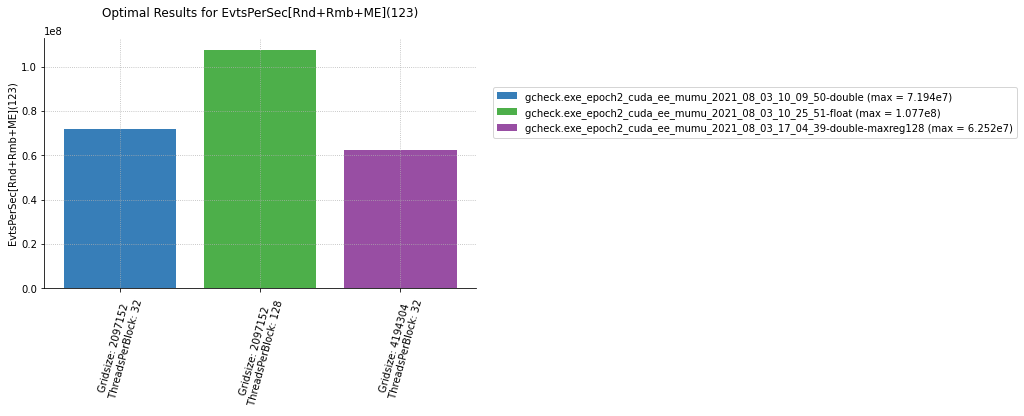

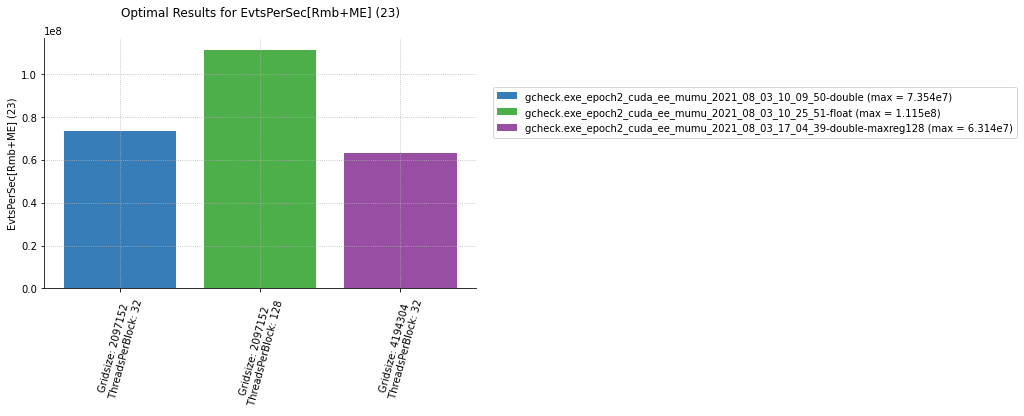

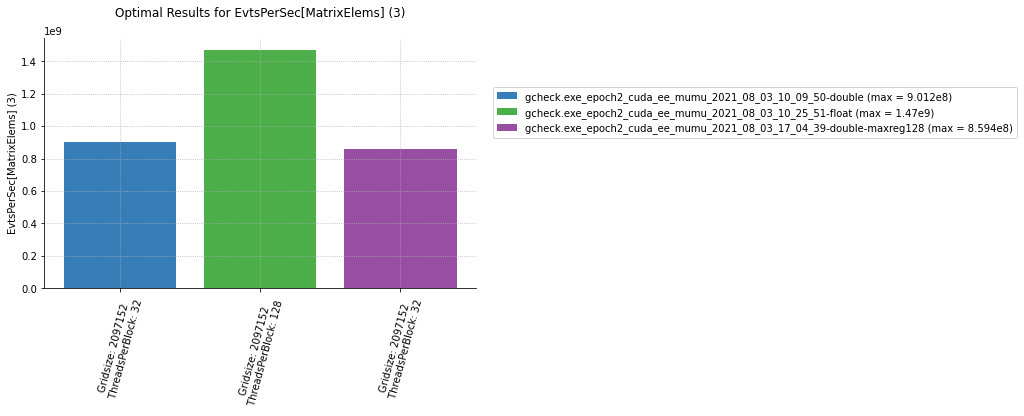

In [105]:
if __name__=='__main__':

    #Sets home directory
    try: 
        print('The home directory has been saved as: ', home_directory)
    except:
        home_directory = os.getcwd()
        print('Saving the home directory as: ', home_directory)

    #instantiate screen display
    s = screens()
    s.run(home_directory)
    os.chdir(home_directory)#Returns to home directory after program is over
